## This example uses Pyramid Wavefront Sensor

In [2]:
import sys
sys.path.insert(1, '../../hcipy')

In [3]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib inline

In [1]:
wavelength_wfs = 842.0E-9 # meter
telescope_diameter = 6.5 # meter
zero_magnitude_flux = 3.9E10
stellar_magnitude = 0


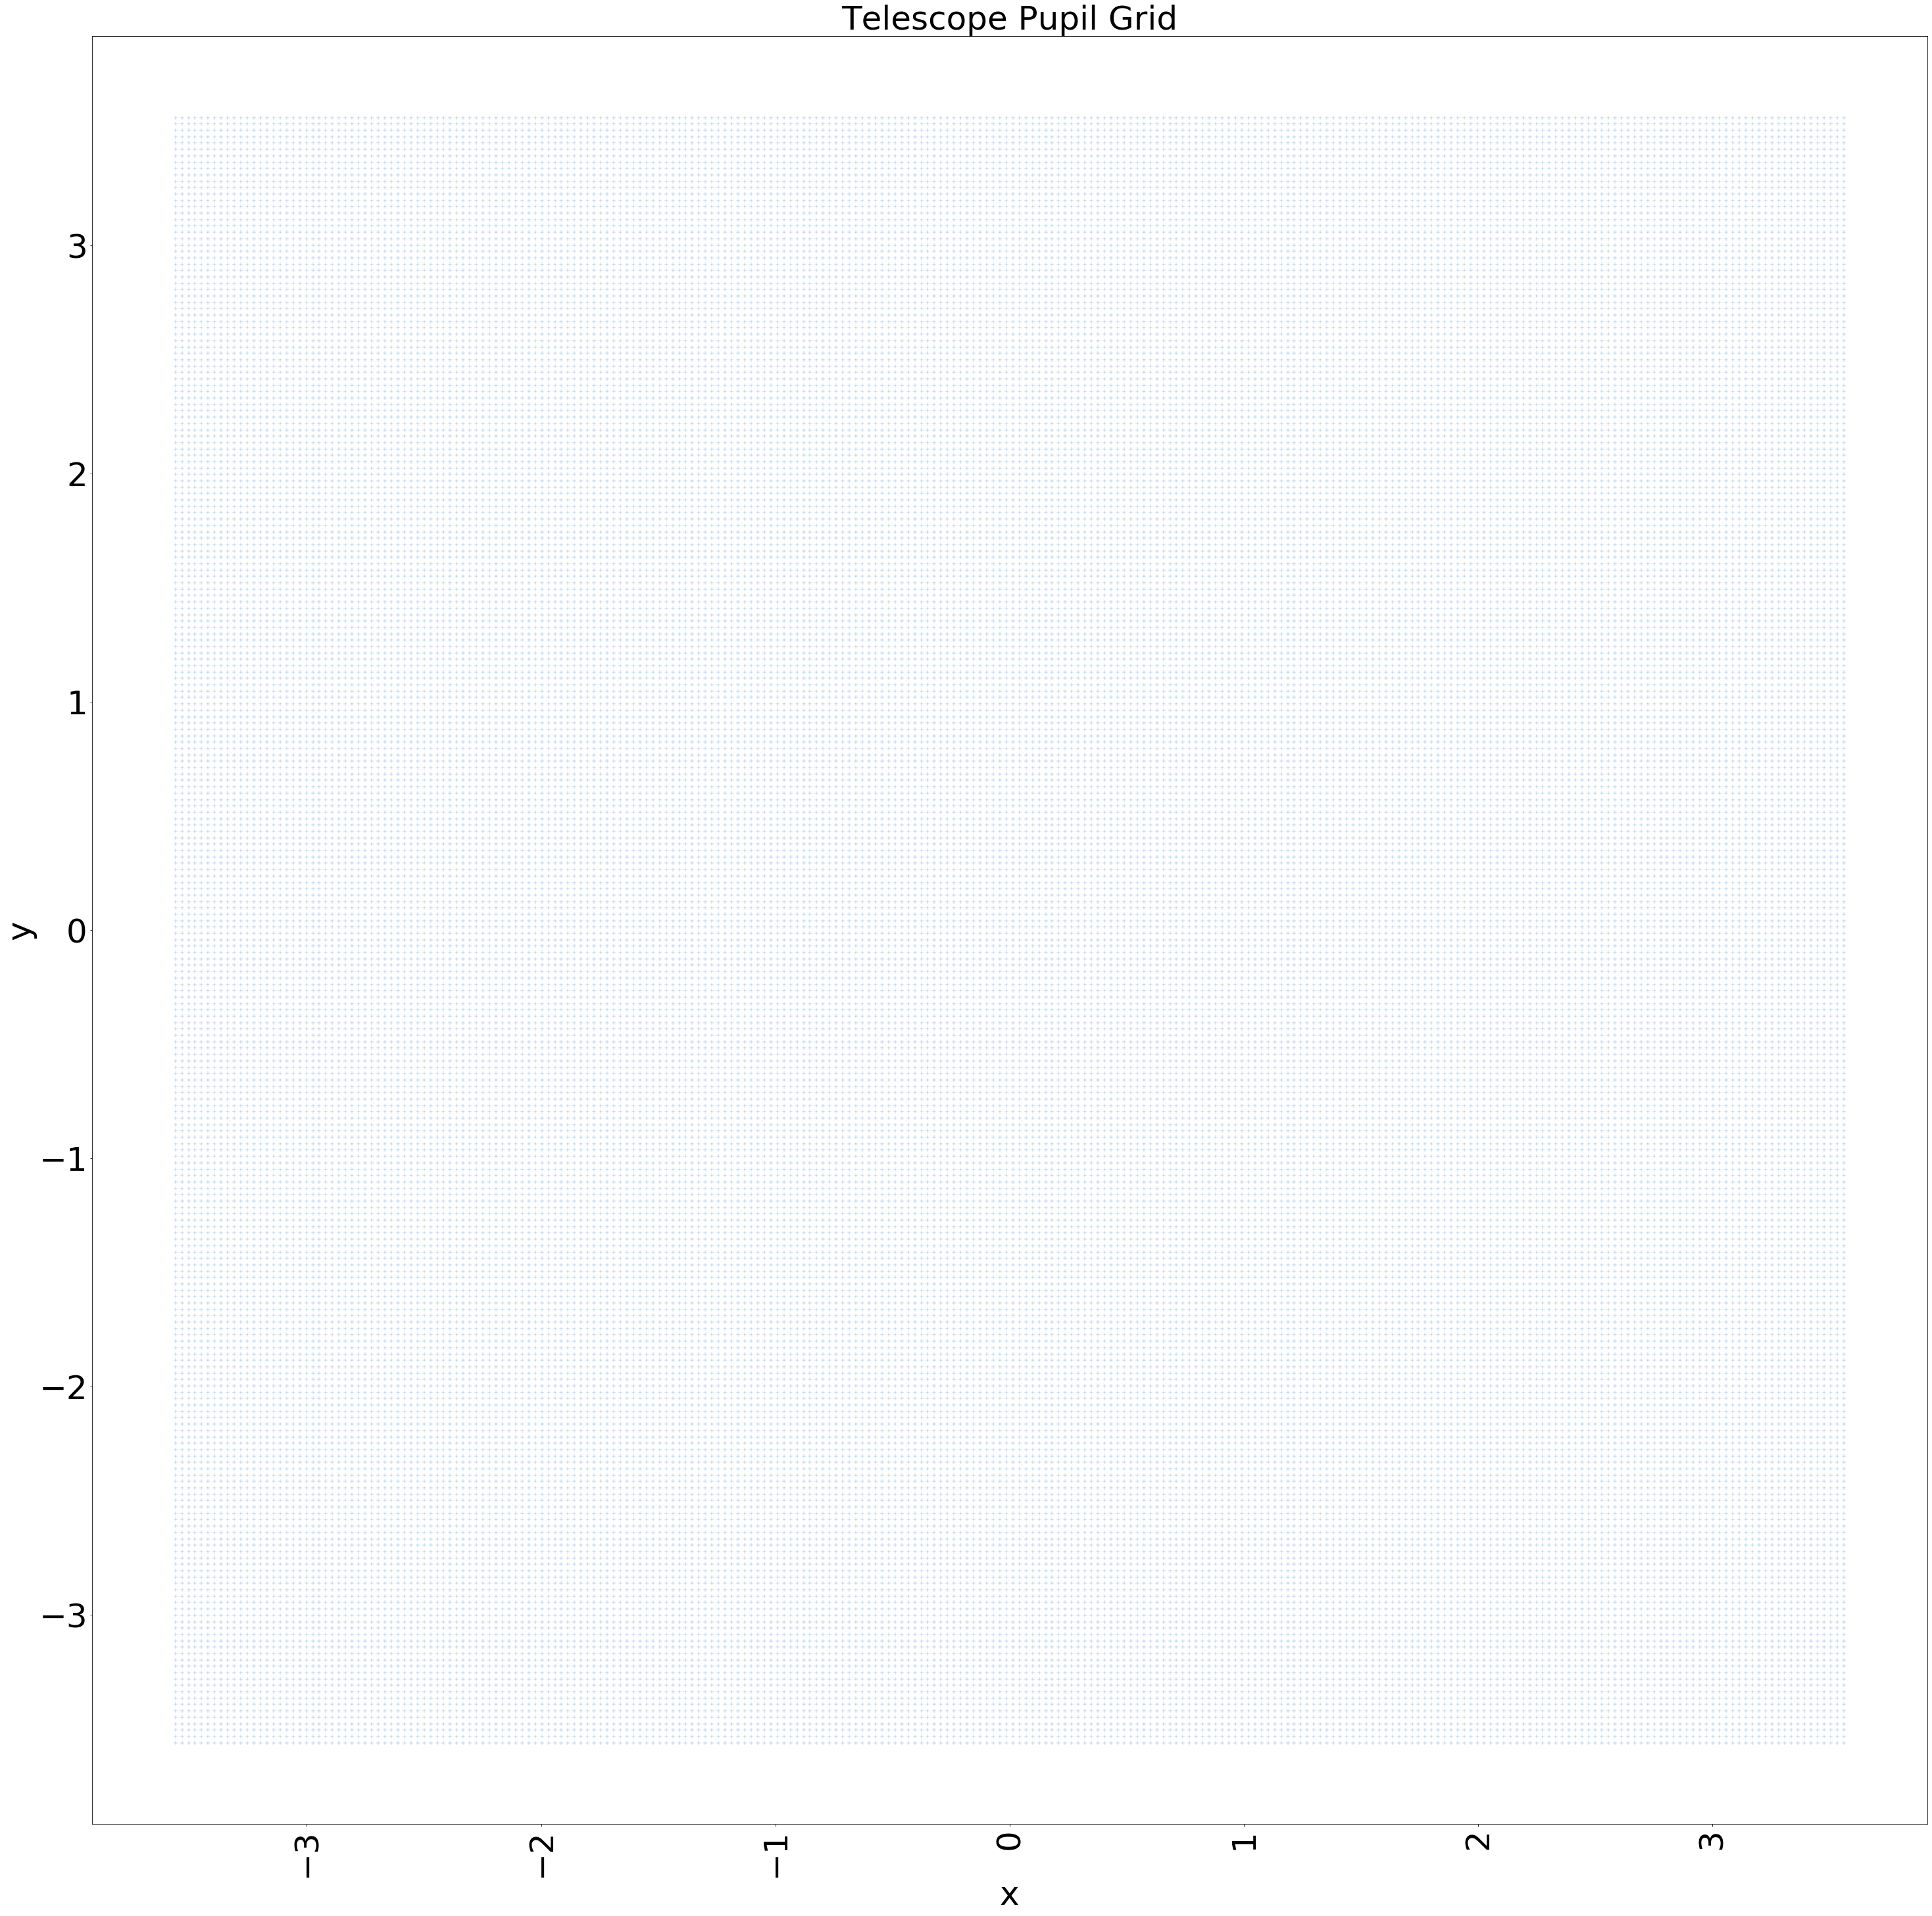

In [93]:
N = 256
telescope_pupil_grid  = make_pupil_grid(N, telescope_diameter*1.1)
## Just plotting something
plt.figure(figsize=(50,50))
plt.plot(telescope_pupil_grid.x, telescope_pupil_grid.y, '+')
plt.title('Telescope Pupil Grid',fontsize=50)
xfont = plt.xlabel('x', fontsize=50)
yfont = plt.ylabel('y', fontsize=50)
xticks = plt.xticks(fontsize=50, rotation=90)
yticks = plt.yticks(fontsize=50, rotation=0)

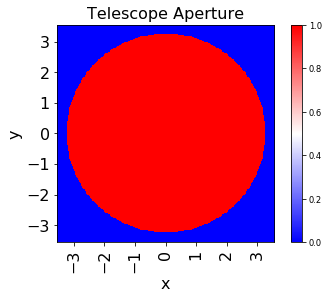

In [94]:
telescope_aperture = circular_aperture(telescope_diameter)
#telescope_aperture_grid = evaluate_supersampled(telescope_aperture, telescope_pupil_grid, 6)

telescope_aperture_grid = telescope_aperture(telescope_pupil_grid)
imshow_field(telescope_aperture_grid, cmap = 'bwr')
plt.colorbar()
plt.title('Telescope Aperture', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)
plt.show()

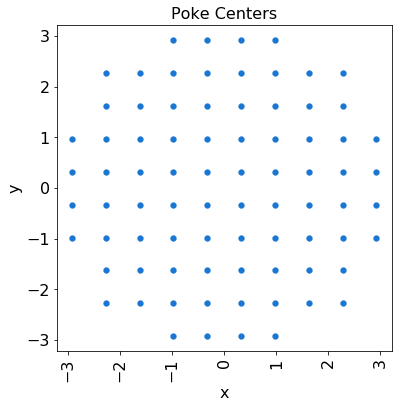

In [95]:
# Make deformable Mirror
num_actuators = 10
pitch = telescope_diameter / num_actuators
poke_centers = make_pupil_grid(num_actuators, telescope_diameter)

poke_centers = poke_centers.subset(poke_centers.as_('polar').r < telescope_diameter / 2)

## Just plotting something
plt.figure(figsize=(6,6))
plt.plot(poke_centers.x, poke_centers.y, 'o')
plt.title('Poke Centers',fontsize=16)
xfont = plt.xlabel('x', fontsize=16)
yfont = plt.ylabel('y', fontsize=16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)

Num of modes = 80


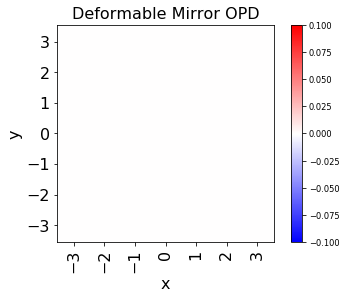

In [96]:
dm_modes = make_gaussian_pokes(telescope_pupil_grid, poke_centers,
                              pitch*np.sqrt(2))
num_modes = poke_centers.x.size
print('Num of modes = {:g}'.format(num_modes))
deformable_mirror = DeformableMirror(dm_modes)

imshow_field(deformable_mirror.opd, cmap = 'bwr')
plt.colorbar()
plt.title('Deformable Mirror OPD', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)
plt.show()

In [97]:
pwfs = PyramidWavefrontSensorOptics(telescope_pupil_grid, wavelength_0=wavelength_wfs)
camera = NoiselessDetector()

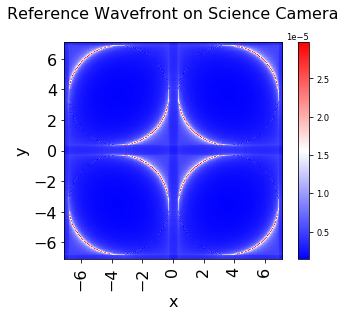

In [98]:
wf_ref = Wavefront(telescope_aperture_grid, wavelength_wfs)
wf_ref.total_power = 1
wf_ref_pwfs_fws = pwfs.forward(wf_ref) 
camera.integrate(wf_ref_pwfs_fws,1)
image_ref = camera.read_out()

# Final reference image is divided by the total sume
# to normalize the wavefron sensor response. Doing this
# consequently for all exposures will make sure that we
# can use this reference for arbitrary exposure times
# and photon flux
image_ref /= image_ref.sum()
imshow_field(image_ref, cmap = 'bwr')
plt.colorbar()
plt.title('Reference Wavefront on Science Camera\n', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)
plt.show()

In [113]:
# Create the interaction matrix
probe_amp = 0.01*wavelength_wfs
slopes = []
wf_ref = Wavefront(telescope_aperture_grid, wavelength_wfs)
wf_ref.total_power = 1


for ind in range(num_modes):
    if (ind+1)%10 == 0:
        print("Mesasure response to mode {:d}/{:d}\n".format(ind+1, num_modes))
    slope = 0
    
    # Probe the phase response
    for s  in [-1, 1]:
        amp = np.zeros((num_modes, ))
        amp[ind] = s * probe_amp
        
        deformable_mirror.actuators = amp
        
        dm_wf = deformable_mirror.forward(wf_ref)
        wfs_wf = pwfs.forward(dm_wf)
        
        camera.integrate(wfs_wf, 1)
        image = camera.read_out()
        image /= np.sum(image)
        
        #if (ind+1)%10 == 0:
        #    imshow_field(image, cmap = 'bwr')
        #    plt.colorbar()
        #    plt.title('Science Camera Image at iteration {}/{}\n'.format(ind, s), fontsize=16)
        #    plt.xlabel('x', fontsize = 16)
        #    plt.ylabel('y', fontsize = 16)
        #    xticks = plt.xticks(fontsize=16, rotation=90)
        #    yticks = plt.yticks(fontsize=16, rotation=0)
        #    plt.show()
        
        slope += s*(image - image_ref)/(2*probe_amp)
        
    slopes.append(slope)
    
slopes = ModeBasis(slopes)



Mesasure response to mode 10/80

Mesasure response to mode 20/80

Mesasure response to mode 30/80

Mesasure response to mode 40/80

Mesasure response to mode 50/80

Mesasure response to mode 60/80

Mesasure response to mode 70/80

Mesasure response to mode 80/80



In [114]:
slopes

In [115]:
rcond = 1E-3
reconstruction_matrix = inverse_tikhonov(slopes.transformation_matrix,
                                        rcond=rcond, svd = None)


In [116]:
### Initialize the wavefront

In [117]:
wf_wfs = Wavefront(telescope_aperture_grid, wavelength_wfs)
wf_wfs.total_power = zero_magnitude_flux*10**(-stellar_magnitude/2.5)

print("Total photon flux {:g}".format(wf_wfs.total_power))

# Put random shape on Deformable Mirror to have something corrected.
deformable_mirror.random(0.1 * wavelength_wfs)

Total photon flux 3.9e+10


In [118]:
AO_Frequency = 1000
delta_t = 1.0 /AO_Frequency
leakage = 0.01
gain = 0.5


In [119]:
input_opd = deformable_mirror.opd
print(input_opd)
print(len(input_opd))

[1.92115760e-08 2.06232861e-08 2.21169263e-08 ... 3.99537943e-08
 3.85292181e-08 3.71152508e-08]
65536


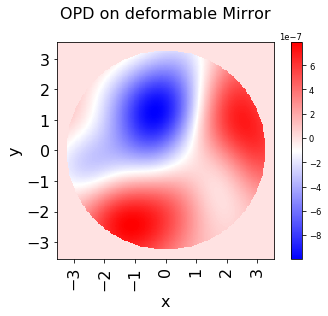

In [120]:

input_opd = telescope_aperture_grid*(input_opd - np.mean(input_opd[telescope_aperture_grid>0]))
imshow_field(input_opd, cmap = 'bwr')
plt.colorbar()
plt.title('OPD on deformable Mirror\n', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)
plt.show()



In [121]:
input_phase_rms = 2*np.pi / wavelength_wfs*np.std(input_opd[telescope_aperture_grid>0])

spatial_resolution = wavelength_wfs/telescope_diameter
focal_grid = make_focal_grid(q = 8, num_airy = 20, 
                            spatial_resolution=spatial_resolution)

propagator = FraunhoferPropagator(telescope_pupil_grid, focal_grid)
wf_prop = propagator.forward(wf_wfs)
Inorm = wf_prop.power.max()
PSF_in = propagator.forward(deformable_mirror.forward(wf_wfs)).power/Inorm

input_strel = PSF_in.max()

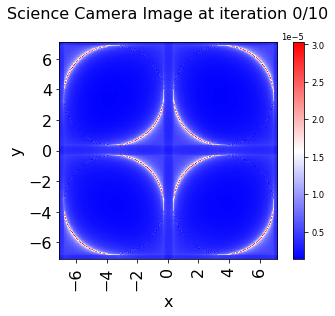

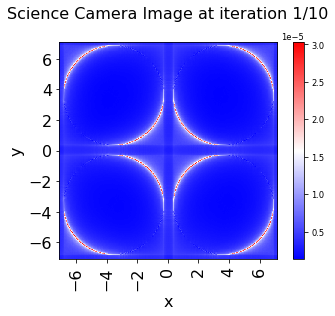

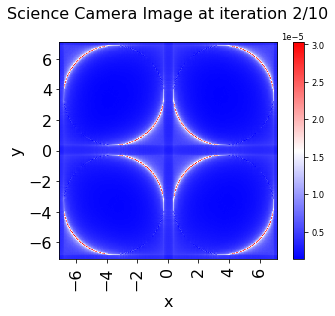

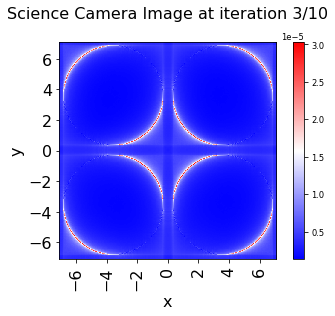

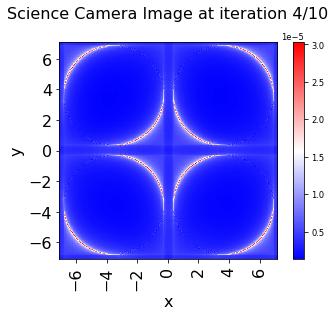

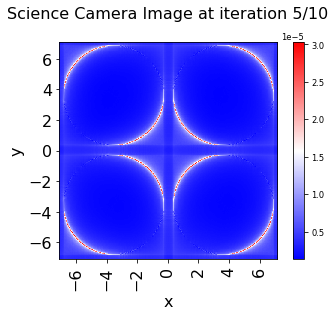

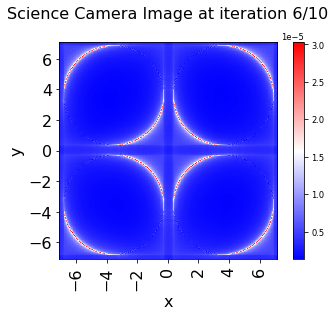

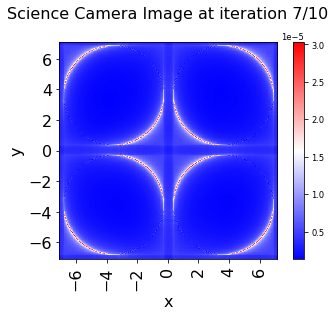

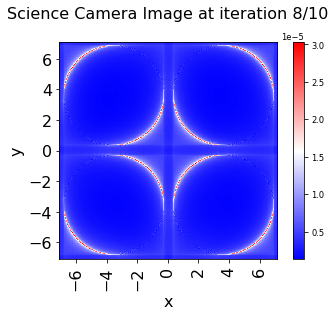

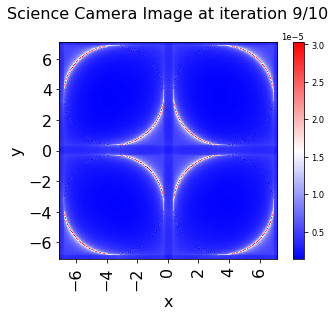

In [122]:
## Run the system in closed loop.
for i in range(10):
    wf_dm = deformable_mirror(wf_wfs)
    wf_pyramid = pwfs.forward(wf_dm)
    camera.integrate(wf_pyramid, 1)
    wfs_image = large_poisson( camera.read_out() ).astype(np.float)
    wfs_image /= np.sum(wfs_image)
    imshow_field(image, cmap = 'bwr')
    plt.colorbar()
    plt.title('Science Camera Image at iteration {}/{}\n'.format(i, 10), fontsize=16)
    plt.xlabel('x', fontsize = 16)
    plt.ylabel('y', fontsize = 16)
    xticks = plt.xticks(fontsize=16, rotation=90)
    yticks = plt.yticks(fontsize=16, rotation=0)
    plt.show()
    
    diff_image = wfs_image - image_ref
    deformable_mirror.actuators = (1 - leakage)*deformable_mirror.actuators - gain*reconstruction_matrix.dot(diff_image)
    
PSF_out = propagator.forward(deformable_mirror.forward(wf_wfs)).power/Inorm

In [123]:
PSF_out

Field([4.97461236e-07, 4.69980817e-08, 1.33818290e-07, ...,
       1.82832778e-06, 8.00447554e-07, 1.51349277e-07])

In [124]:
## Comparison

residual_opd = deformable_mirror.opd
residual_opd = telescope_aperture_grid*(residual_opd - np.mean(residual_opd[telescope_aperture_grid>0]))

phase_rms = 2*np.pi/wavelength_wfs*np.std(residual_opd[telescope_aperture_grid>0])
strehl = PSF_out.max()

print("Estimated Strehl Input {:g} and Output {:g}".format(
input_strel, strehl))

Estimated Strehl Input 0.085776 and Output 0.963262


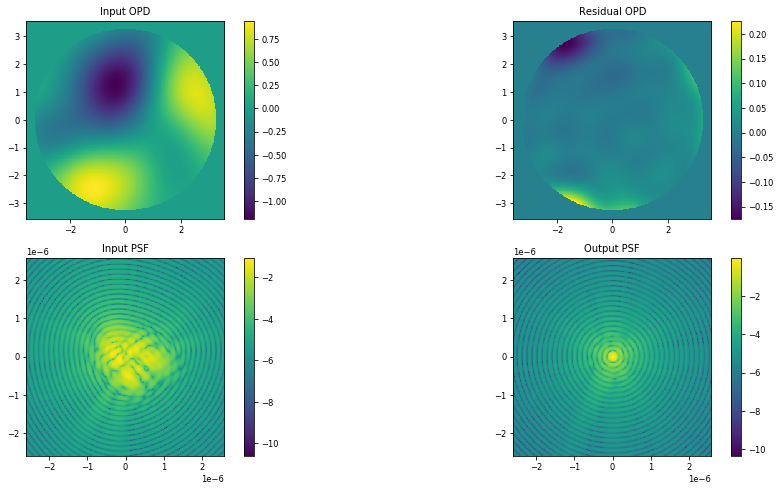

In [126]:
plt.figure(figsize=(16, 8))
plt.subplot(2,2,1)
imshow_field(input_opd/wavelength_wfs)
plt.title('Input OPD')
plt.colorbar()

plt.subplot(2,2,2)
imshow_field(residual_opd/wavelength_wfs)
plt.title('Residual OPD')
plt.colorbar()

plt.subplot(2,2,3)
imshow_field(np.log10(PSF_in))
plt.title('Input PSF')
plt.colorbar()

plt.subplot(2,2,4)
imshow_field(np.log10(PSF_out))
plt.title('Output PSF')
plt.colorbar()
